In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
sns.set(style="whitegrid", color_codes=True)
matplotlib.style.use('ggplot')

In [2]:
%matplotlib inline

In [3]:
file= r'takehome_user_engagement.csv'

In [4]:
#note: the datetime can also be converted to a format that pandas can manipulate using the to_datetime(), which returns a new
#result. it doesn't modify its argument in place, one needs to reassign it such as 
#df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d %H:%M:%SZ') 

df= pd.read_csv(file, parse_dates=['time_stamp'])
#df= pd.read_csv(file, parse_dates=['time_stamp'], index_col= 'time_stamp')

In [5]:
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#checking total rows and columns
df.shape

(207917, 3)

In [7]:
#checking for duplicate rows in the dataset. This means no user log into the platform more than once each day
df.duplicated().sum()

0

In [8]:
#checking for null values
df.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

**Feature Engineering**

Based on requirement in the case study, a new feature needs to be engineered based on the following outcomes:
- the new variable should be called adopted user
- this user is one who logged into the product on three separate days
- this logging in event should be in at least one seven-day period

In [9]:
df.index = df['time_stamp']

In [10]:
df.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [11]:
df2 = df.drop('time_stamp', axis = 1)
df2.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


Note: You can get the same results above if you just specify the index column when reading the data in as already mentioned. I decided taking this approach so i can check for duplicates rows. I noticed making the time series the index right out of the bat provides different results compared to not having it set because duplicate checks look at the values and not the indexes.  

In [12]:
df3 = df2.groupby([pd.TimeGrouper('W'), 'user_id']).agg({'visited': np.sum})
df3.head()

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1

In [13]:
df4 = df3[df3.iloc[:, 0] == 3]
df4.head()

visited
time_stamp user_id         
2012-06-10 1693           3
2012-06-17 11764          3
2012-06-24 1693           3
           5297           3
2012-07-01 6171           3

In [14]:
df5 = df4.reset_index()
df5.head()

,time_stamp,user_id,visited
0,2012-06-10,1693,3
1,2012-06-17,11764,3
2,2012-06-24,1693,3
3,2012-06-24,5297,3
4,2012-07-01,6171,3


In [15]:
df6= df5['user_id'].unique()
df6

array([ 1693, 11764,  5297, ..., 10746,  8460,  8463], dtype=int64)

In [16]:
for user in df6: 
    df['adopted_user'] = df['user_id'].astype(str).str.contains(str(user))

In [17]:
df.drop('time_stamp', axis =1). reset_index().head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,False
2,2013-11-29 03:45:04,2,1,False
3,2013-12-09 03:45:04,2,1,False
4,2013-12-25 03:45:04,2,1,False


In [18]:
df['adopted_user'].value_counts()

False    207887
True         30
Name: adopted_user, dtype: int64

We now need to merge the DataFrame with the engineered feature with the second provided DataFrame to determine important feature that can predict the created adopted user. It will be using a full outer join, more like what you have in Cartesian product in SQL

In [19]:
file2= r'takehome_users.csv'

In [20]:
#df7= pd.read_csv(file2, encoding='ISO-8859-1', parse_dates=['creation_time'])
df7= pd.read_csv(file2, encoding='ISO-8859-1')


In [21]:
df7.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [22]:
df7.shape

(12000, 10)

In [23]:
#renaming object_id to user_id since they are basically the same to allow joining of the two dataframes
df7=df7.rename(columns = {'object_id':'user_id'})

In [24]:
df7.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [25]:
df7.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [26]:
#checking for missing values
df7.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [27]:
from sklearn.base import TransformerMixin
#this class was used to impute missing values
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill) 

In [28]:
#imputing missing values.
df8 = DataFrameImputer().fit_transform(df7)
df8.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [29]:
#showing all missing values filled in
df8.isnull().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [30]:
#merging df8 and df into one dataframe using full outer join, more like what you have in Cartesian product in SQL. 
df9 = pd.merge(df8, df, on='user_id')

In [31]:
df9.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1,False
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1,False
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1,False
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1,False


In [32]:
#here we see the effect of the full outer join compared with its individual DataFrame components.
df9.shape

(207917, 13)

In [33]:
#converting the unix timestamp of last login to datetime format in Pandas to allow uniformity and time series analysis   
df9['last_session_creation_time'] = pd.to_datetime(df9['last_session_creation_time'],unit='s')

In [34]:
df9.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22 03:53:30,1,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15 03:45:04,1,False
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29 03:45:04,1,False
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09 03:45:04,1,False
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25 03:45:04,1,False


In [35]:
df10 = df9.drop(['name', 'email'], axis = 1)

In [36]:
#checking for missing values
df10.isnull().sum()

user_id                       0
creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
time_stamp                    0
visited                       0
adopted_user                  0
dtype: int64

In [37]:
df10.dtypes

user_id                                int64
creation_time                         object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
time_stamp                    datetime64[ns]
visited                                int64
adopted_user                            bool
dtype: object

In [38]:
df10['creation_time']= pd.to_datetime(df10['creation_time'])

In [39]:
#courtesy: https://stackoverflow.com/questions/37192220/convert-date-time-format-to-unix-time-stamp-pandas
df10['creation_time']= df10['creation_time'].astype(np.int64) / 10**9
df10['last_session_creation_time']= df10['last_session_creation_time'].astype(np.int64) / 10**9
df10['time_stamp']= df10['time_stamp'].astype(np.int64) / 10**9

In [40]:
df10.head()

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,1.398139e+09,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,False
1,2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.384487e+09,1,False
2,2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.385697e+09,1,False
3,2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.386561e+09,1,False
4,2,1.384487e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.387943e+09,1,False


**Hot coding categorical variables**

In [63]:
#selecting 2 features to hard code
some_var1 = ['creation_source']

#hot code the features
hot_code = pd.get_dummies(df10[some_var1])

#drop original variables once dummy variables have been created 
dfg = df10.drop(['creation_source'], axis=1)

#merge the created dummy variables with the original dataframe and reset the index for the overall dataframe
df11 = pd.concat([dfg, hot_code], axis=1).reset_index(drop=True)
df11.head()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1.398139e+09,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,False,1,0,0,0,0
1,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.384487e+09,1,False,0,1,0,0,0
2,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.385697e+09,1,False,0,1,0,0,0
3,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.386561e+09,1,False,0,1,0,0,0
4,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.387943e+09,1,False,0,1,0,0,0


My guess is the email address and names will not be significant. They are causing unnecessary high dimensionality here. However, i will leave them in here to see how the machine learning model performs.

In [64]:
#selecting the boolean features in preparation to be hot coded
some_var2 = ['adopted_user']

#hot coding of the boolean features
for x in some_var2:
    df11[x] = (df11[x] == True).astype(int)

In [83]:
df11.head()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1.398139e+09,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,0,1,0,0,0,0
1,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.384487e+09,1,0,0,1,0,0,0
2,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.385697e+09,1,0,0,1,0,0,0
3,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.386561e+09,1,0,0,1,0,0,0
4,2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.387943e+09,1,0,0,1,0,0,0


In [84]:
X = df11.drop('adopted_user', axis=1)
y = df11['adopted_user']

In [85]:
X.shape, y.shape

((207917, 14), (207917,))

In [86]:
#Shows the number of unique labels in our target variable. 
len(y.unique())

2

In [87]:
#shows the unique labels/classes themselves
y.unique()

array([0, 1], dtype=int64)

In [88]:
#shows the number of examples/observations in each classes.
y.value_counts()

0    207887
1        30
Name: adopted_user, dtype: int64

This is an imbalanced dataset. We can fix it thus:

In [96]:
from sklearn.utils import resample

In [97]:
df_majority = df11[df11['adopted_user'] == 0]

In [98]:
df_minority = df11[df11['adopted_user'] == 1]

In [99]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=207887,    # to match majority class
                                 random_state=123) # reproducible results

In [100]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [101]:
df_upsampled['adopted_user'].value_counts()

1    207887
0    207887
Name: adopted_user, dtype: int64

In [102]:
df_upsampled.shape

(415774, 15)

In [103]:
D = df_upsampled.drop('adopted_user', axis=1)
E = df_upsampled['adopted_user']

In [104]:
# Split the data into 40% test and 60% training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(D, E, test_size=0.4, random_state=0)

In [105]:
X_train.shape, X_test.shape

((249464, 14), (166310, 14))

In [106]:
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [107]:
# Train the classifier
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [108]:
#Print the name and gini importance of each feature
for feature in zip(X.columns, clf.feature_importances_):
    print(feature)

('user_id', 0.053988234442961726)
('creation_time', 0.28732342545804707)
('last_session_creation_time', 0.11763400544774912)
('opted_in_to_mailing_list', 0.07160733337989092)
('enabled_for_marketing_drip', 0.0012146535457789379)
('org_id', 0.1033906171988626)
('invited_by_user_id', 0.20939676667892801)
('time_stamp', 0.11270147973608673)
('visited', 0.0)
('creation_source_GUEST_INVITE', 0.0061064037477560956)
('creation_source_ORG_INVITE', 0.031891756827678898)
('creation_source_PERSONAL_PROJECTS', 3.845579494606626e-05)
('creation_source_SIGNUP', 0.0033440194715566962)
('creation_source_SIGNUP_GOOGLE_AUTH', 0.0013628482697573426)


In [109]:
feature_rank = pd.DataFrame(clf.feature_importances_)
feature_rank.columns = ['rank'] 

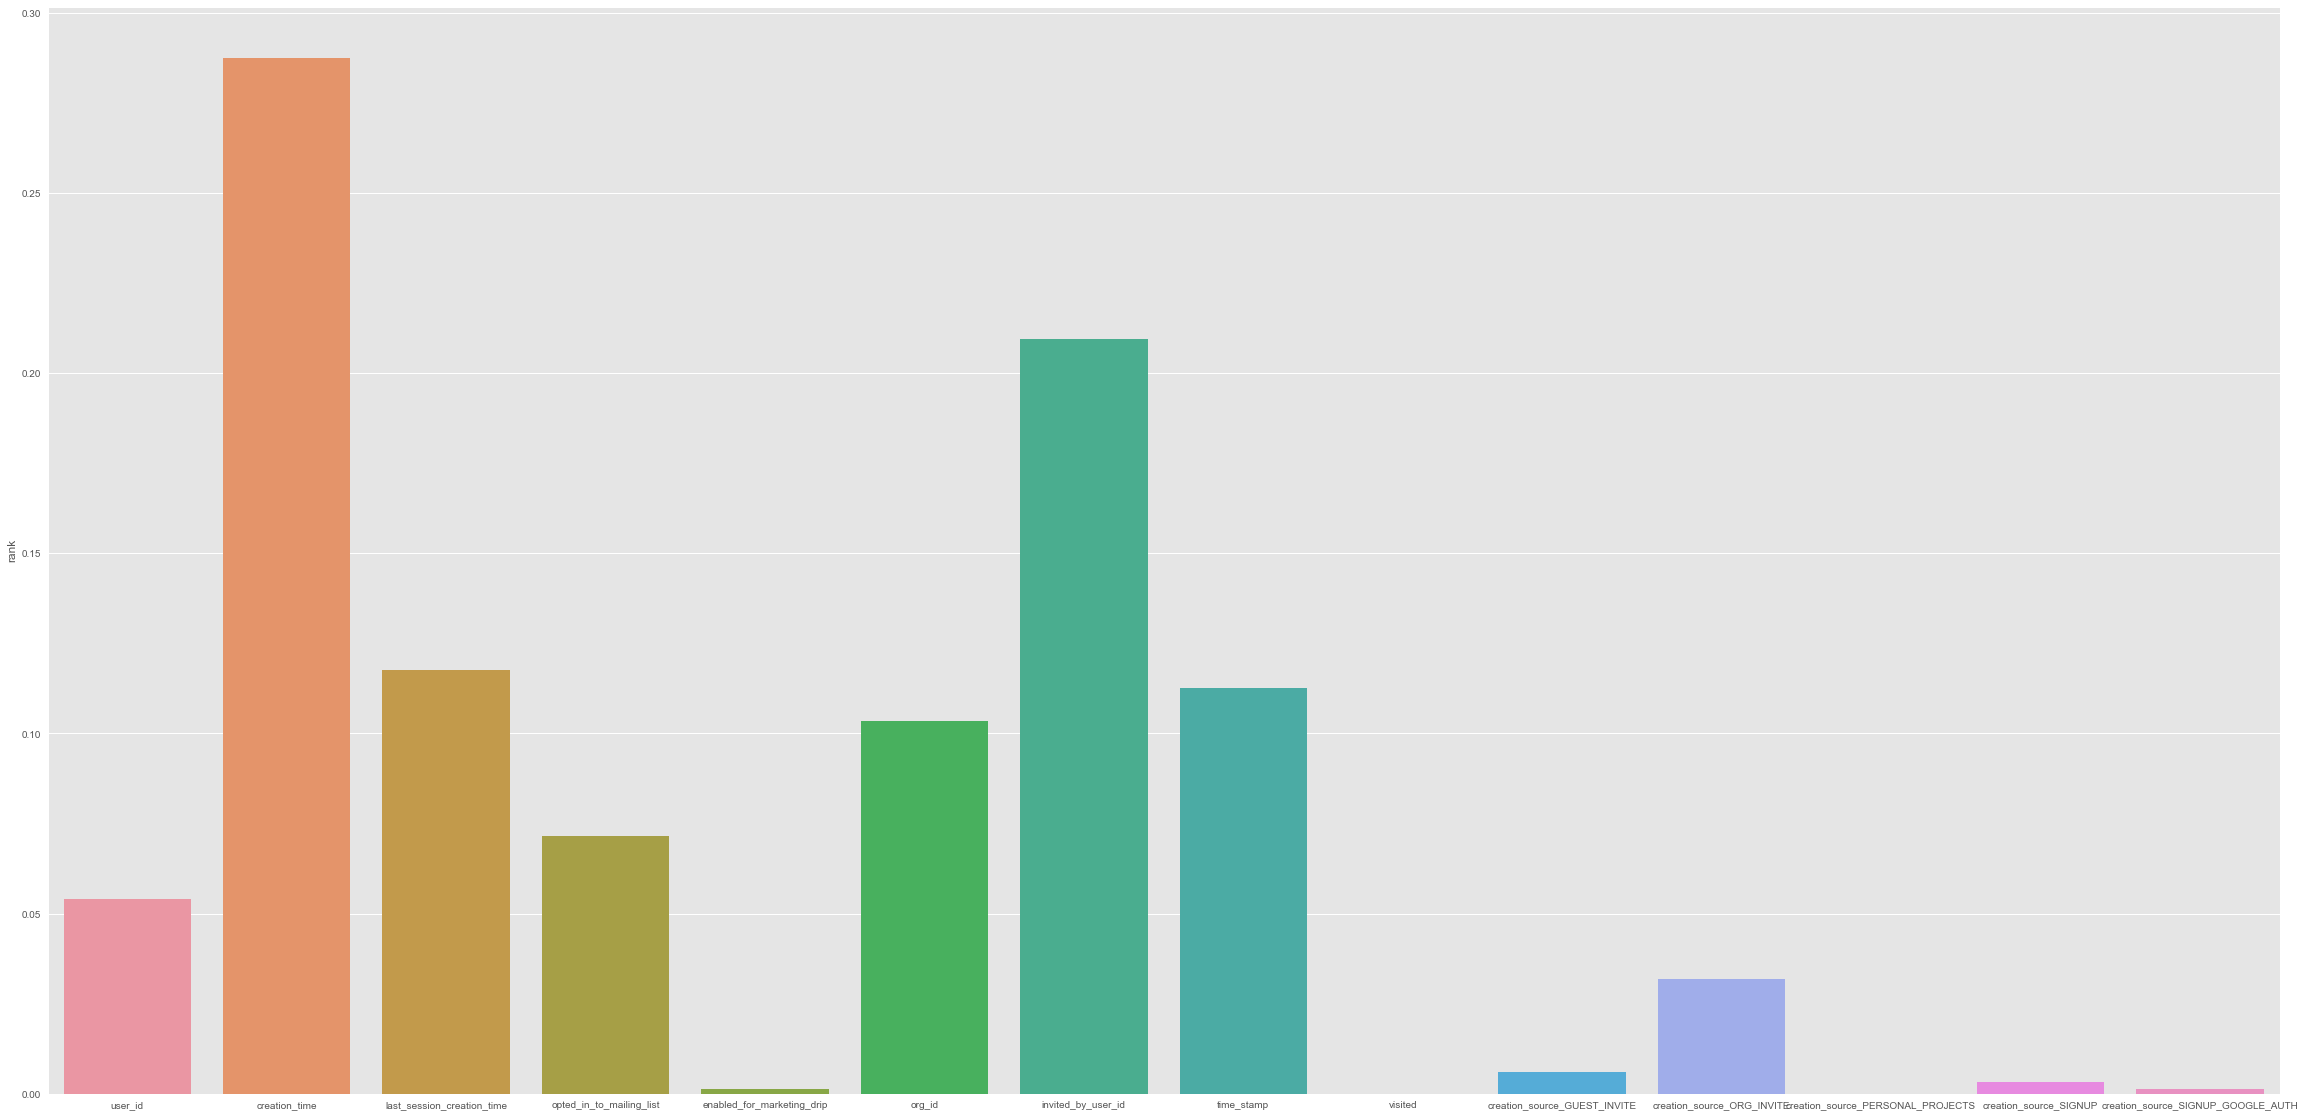

In [110]:
plt.figure(figsize=(40,20)) # this creates a figure 8 inch wide, 4 inch high
sns.barplot(x = X.columns, y = 'rank',  data = feature_rank, order = X.columns )
plt.show()

In [163]:
features = pd.DataFrame(X.columns, columns=['features'])

In [164]:
imprt_features = pd.concat([features, feature_rank], axis= 1)
all_features_rank = imprt_features.sort_values(by=['rank'], ascending=False)
all_features_rank

,features,rank
1,creation_time,0.287323
6,invited_by_user_id,0.209397
2,last_session_creation_time,0.117634
7,time_stamp,0.112701
5,org_id,0.103391
3,opted_in_to_mailing_list,0.071607
0,user_id,0.053988
10,creation_source_ORG_INVITE,0.031892
9,creation_source_GUEST_INVITE,0.006106
12,creation_source_SIGNUP,0.003344


In [165]:
#important features at the 0.05 mark. 
imprt_features= all_features_rank[all_features_rank['rank'] > 0.05]
imprt_features

,features,rank
1,creation_time,0.287323
6,invited_by_user_id,0.209397
2,last_session_creation_time,0.117634
7,time_stamp,0.112701
5,org_id,0.103391
3,opted_in_to_mailing_list,0.071607
0,user_id,0.053988


 The factors above at the 0.05 cut off mark can predict future user adoption in decreasing order of importance 